In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [2]:
# read in pickled features
df_sj = pd.read_pickle('./dataset/all_sj.pkl')
df_iq = pd.read_pickle('./dataset/all_iq.pkl')

total_cases = pd.read_csv('./dataset/dengue_labels_train.csv')
cases_sj = total_cases[total_cases['city'] == 'sj']['total_cases']
cases_iq = total_cases[total_cases['city'] == 'iq']['total_cases']

# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

In [3]:
# train test split
#sj

# choose split dates
sj_valid_split = '2003-4-20'
sj_test_split = '2008-4-27' # this will split between pre and post submission dates

# split into train, valid, test (no y)
sj_train = df_sj.loc[:sj_valid_split]
sj_Xtrain = sj_train
sj_ytrain = cases_sj[:len(sj_train)]

sj_valid = df_sj.loc[sj_valid_split : sj_test_split]
sj_Xvalid = sj_valid
sj_yvalid = cases_sj[len(sj_train):]

sj_test = df_sj.loc[sj_test_split:]
sj_Xtest = sj_test


In [4]:
#iq

# choose split dates
iq_valid_split = '2007-7-01'
iq_test_split = '2010-7-01' # this will split between pre and post submission dates

# split
iq_train = df_iq.loc[:iq_valid_split]
iq_Xtrain = iq_train
iq_ytrain = cases_iq[:len(iq_Xtrain)]

iq_valid = df_iq.loc[iq_valid_split : iq_test_split]
iq_Xvalid = iq_valid
iq_yvalid = cases_iq[len(iq_train):]

iq_test = df_iq.loc[iq_test_split:]
iq_Xtest = iq_test


In [5]:

print (len(pd.get_dummies(sj_Xtrain['month'], prefix='month')), len(sj_ytrain.values))
print (len(pd.get_dummies(sj_Xvalid['month'], prefix='month')), len(sj_yvalid.values))

675 675
261 261


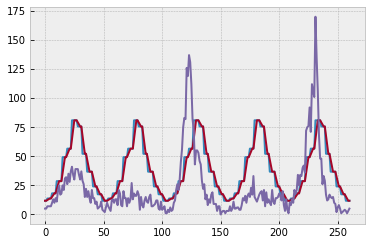

24.395833333333332
25.20522030651341


In [6]:
# sj monthly trend

lr_sj = LinearRegression()
X = pd.get_dummies(sj_Xtrain['month'], prefix='month')
y = sj_ytrain.values

lr_sj.fit(X, y)
monthly_trend_train = pd.Series(lr_sj.predict(X)).rolling(3, min_periods = 1).mean()
sj_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(sj_Xvalid['month'], prefix='month')
ytest = sj_yvalid.values
monthly_trend_valid = pd.Series(lr_sj.predict(Xtest)).rolling(3, min_periods=1).mean()
sj_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_sj.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

print (mean_absolute_error(lr_sj.predict(Xtest), ytest))
print (mean_absolute_error(monthly_trend_valid, ytest))

-16.12236590038314
675 261


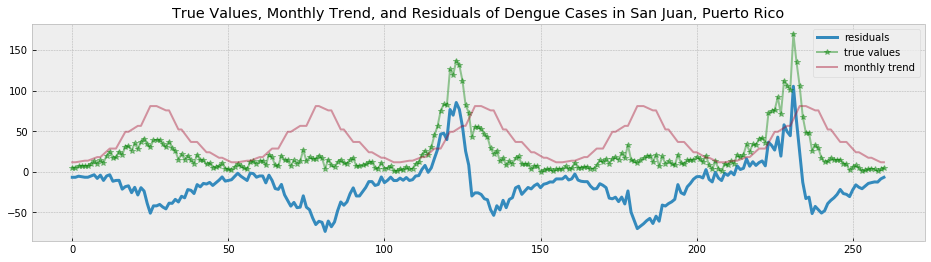

In [7]:
# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(sj_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in San Juan, Puerto Rico')
plt.legend()
print (np.mean(sj_residuals_test))

print (len(sj_residuals_train), len(sj_residuals_test))

615 615
201 201
25.48995970139475
-0.10823488503472456


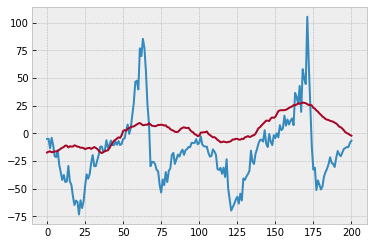

In [8]:
# munge data

# max roll back set to 59

# rolling means df
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 52).mean()[60:675]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 10).mean()[60:675]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_train[60:]

print (len(Xtrain), len(ytrain))

# rolling means df
Xvalid_means1 = df_sj['station_avg_temp_c'].rolling(window = 53).mean()[675:936]
Xvalid_means2 = df_sj['ndvi_se'].rolling(window = 10).mean()[675:936]

# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = sj_residuals_test[60:]

print (len(Xvalid), len(yvalid))

# fit on model, predict
lr_sj_residual = LinearRegression()
lr_sj_residual.fit(Xtrain, ytrain)

sj_valid_preds = lr_sj_residual.predict(Xvalid)

print (mean_absolute_error(sj_valid_preds, yvalid))
print (lr_sj_residual.score(Xvalid, yvalid))
plt.plot(yvalid.values)
plt.plot(sj_valid_preds)

In [9]:
print (len(pd.get_dummies(iq_Xtrain['month'], prefix='month')), len(iq_ytrain.values))
print (len(pd.get_dummies(iq_Xvalid['month'], prefix='month')), len(iq_yvalid.values))

364 364
156 156


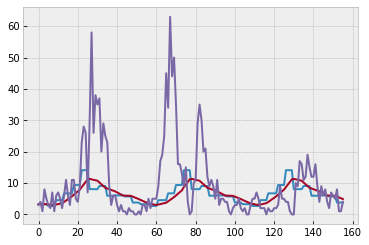

7.050430689102564
6.92185751170126


In [10]:
# iq monthly trend

lr_iq = LinearRegression()
X = pd.get_dummies(iq_Xtrain['month'], prefix='month')
y = iq_ytrain.values

lr_iq.fit(X, y)
monthly_trend_train = pd.Series(lr_iq.predict(X)).rolling(9, min_periods = 1).mean()
iq_residuals_train = y - monthly_trend_train


# on validation data
# note: monthly trend does not need previous weeks data, so this can use the validation set
Xtest = pd.get_dummies(iq_Xvalid['month'], prefix='month')
ytest = iq_yvalid.values
monthly_trend_valid = pd.Series(lr_iq.predict(Xtest)).rolling(9, min_periods=1).mean()
iq_residuals_test = ytest - monthly_trend_valid

# plot
plt.plot(lr_iq.predict(Xtest))
plt.plot(monthly_trend_valid)
plt.plot(ytest)
plt.show()

print (mean_absolute_error(lr_iq.predict(Xtest), ytest))
print (mean_absolute_error(monthly_trend_valid, ytest))

3.4263996998371997


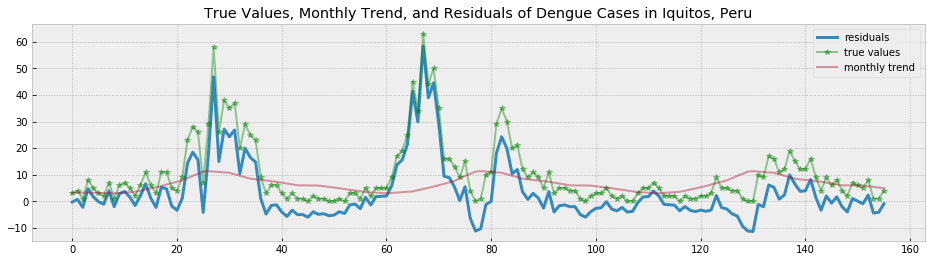

In [11]:
# Find the residuals of the monthly trend

plt.figure(figsize=(16, 4))
plt.plot(iq_residuals_test, label = 'residuals', linewidth = 3)
plt.plot(ytest, 'g-*', alpha = .4, label = 'true values')
plt.plot(monthly_trend_valid, alpha = .4, label = 'monthly trend')
plt.title('True Values, Monthly Trend, and Residuals of Dengue Cases in Iquitos, Peru')
plt.legend()
print (np.mean(iq_residuals_test))

0.05670430593191833
6.957011058670287


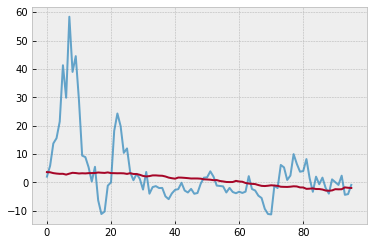

In [12]:
# rolling mean of feature to predict residuals

# munge data

# max roll back set to 59

# set up training data
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[60:364]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_train[60:]

# print len(Xtrain), len(ytrain)

# set up validation data
# rolling means df
Xvalid_means1 = df_iq['station_avg_temp_c'].rolling(window = 53).mean()[364:520]

# combine all dfs
Xvalid = pd.concat([Xvalid_means1], axis = 1)[60:]
yvalid = iq_residuals_test[60:]

# print len(Xvalid), len(yvalid)

# model it!

lr_iq_resids = LinearRegression()
lr_iq_resids.fit(Xtrain, ytrain)

iq_valid_preds = lr_iq_resids.predict(Xvalid)

# plot iq residual predictions
plt.plot(yvalid.values, alpha = .75)
plt.plot(iq_valid_preds)
print (lr_iq_resids.score(Xvalid, yvalid))
print (mean_absolute_error(iq_valid_preds, yvalid))

In [13]:
# transform sj data

month_dums = pd.get_dummies(df_sj['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_sj[['station_avg_temp_c']].rolling(window = 55).mean())
# temp_roll_std = pd.DataFrame(df_sj[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test set
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)

# train model
lr_sj_full = LinearRegression()
lr_sj_full.fit(Xtest[60:-260], cases_sj.values[60:])

# predicts
sj_full_preds = lr_sj_full.predict(Xtest[55:])
sj_submit_preds = sj_full_preds[-260:]

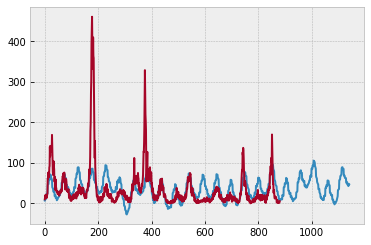

In [14]:
plt.plot(sj_full_preds)
plt.plot(cases_sj.values[55:])

In [15]:
# transform iq data
month_dums = pd.get_dummies(df_iq['month'], prefix='month')
temp_roll_means = pd.DataFrame(df_iq[['ndvi_nw']].rolling(window = 68).mean())
# temp_roll_std = pd.DataFrame(df_iq[['station_avg_temp_c', 'precipitation_amt_mm']].rolling(window = 8).mean())

# combine into test
Xtest = pd.concat([month_dums, temp_roll_means], axis = 1)

# train
lr_iq_full = LinearRegression()
lr_iq_full.fit(Xtest[68:-156], cases_iq.values[68:])

# predicts
iq_full_preds = lr_iq_full.predict(Xtest[68:])
iq_submit_preds = iq_full_preds[-156:]

In [16]:
total_preds = list(sj_submit_preds) + list(iq_submit_preds)

submission_format = pd.read_csv('./dataset/submission_format.csv')

submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

submission_format.to_csv('submissions/LFR1.csv', index=False)


In [17]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold

def xgb_regressor_model(X_train, y_train):
    regressor = XGBRegressor(n_jobs=-1, random_state=1)

    max_depth = range(1,11)
    learning_rate = [0.001, 0.01, 0.1]
    n_estimators = range(0, 1000, 10)

    param_grid = dict(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

    grid_search = GridSearchCV(estimator = regressor, 
                               param_grid = param_grid, 
                               scoring="neg_mean_absolute_error", 
                               n_jobs=1,
                               refit=True, 
                               cv=KFold(5), 
                               verbose=5)
    grid_result = grid_search.fit(X=X_train, y=y_train)
    print("Best: Mean: %f, Std: %f using %s" % (grid_result.best_score_,
                                 grid_result.cv_results_['std_test_score'][grid_result.best_index_],
                                 grid_result.best_params_))
    
    return grid_result


Residual Prediction model with monthly trend

In [320]:
# get monthly trend of whole test df
lr_sj_month = LinearRegression()
# lr_sj_month = RandomForestRegressor()
X_months = pd.get_dummies(df_sj['month'], prefix='month')[:936]
Xtest_months = pd.get_dummies(df_sj['month'], prefix='month')[936:]
y = cases_sj.values

lr_sj_month.fit(X_months, y)
monthly_trend = pd.Series(lr_sj_month.predict(X_months)).rolling(3, min_periods=1).mean()
sj_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_sj['station_avg_temp_c'].rolling(window = 53, min_periods =1).mean()[60:936]
Xtrain_means2 = df_sj['ndvi_se'].rolling(window = 53, min_periods =1).mean()[60:936]
Xtrain_means3 = df_sj['reanalysis_specific_humidity_g_per_kg'].rolling(window = 53, min_periods =1).mean()[60:936]
Xtrain_means4 = df_sj['reanalysis_avg_temp_k'].rolling(window = 53, min_periods =1).mean()[60:936]
# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = sj_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df
Xtest_means1 = df_sj['station_avg_temp_c'].rolling(window = 53, min_periods =1).mean()[936:]
Xtest_means2 = df_sj['ndvi_se'].rolling(window = 53, min_periods =1).mean()[936:]
Xtest_means3 = df_sj['reanalysis_specific_humidity_g_per_kg'].rolling(window = 53, min_periods =1).mean()[936:]
Xtest_means4 = df_sj['reanalysis_avg_temp_k'].rolling(window = 53, min_periods =1).mean()[936:]

# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)
# print(Xtest_weather)
# fit on model
# lr_sj_resid = LinearRegression()
lr_sj_resid = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=67)

lr_sj_resid.fit(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=67, verbose=0, warm_start=False)

In [321]:
# make predictions on monthly data and residual data
sj_monthly_preds = pd.Series(lr_sj_month.predict(Xtest_months)).rolling(3, min_periods=1).mean()
sj_resid_preds = lr_sj_resid.predict(Xtest_weather)
sj_cases_pred = pd.Series(sj_resid_preds + sj_monthly_preds).rolling(1, min_periods=1).mean()
sj_cases_pred = sj_cases_pred.apply(lambda x: 1 if x < 1 else int(x))



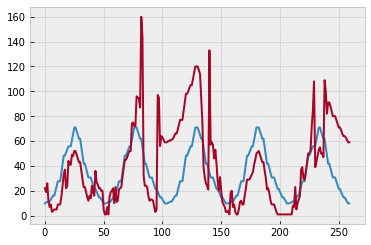

In [322]:
# plt.plot(sj_resid_preds)
plt.plot(sj_monthly_preds)
plt.plot(sj_cases_pred)

Text(0,0.5,'Cases')

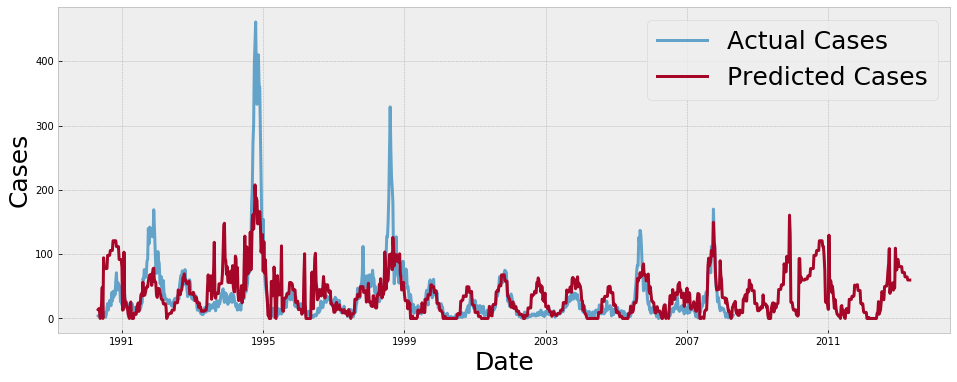

In [323]:
### make plot of best model predictions and actual cases over all time period for sj

# monthly trend
sj_month_preds = lr_sj_month.predict(pd.get_dummies(df_sj['month'], prefix='month'))
# predicted residuals
weather1 = df_sj[['station_avg_temp_c']].rolling(window=53, min_periods=1).mean()
weather2 = df_sj[['ndvi_se']].rolling(window=53, min_periods=1).mean()
weather3 = df_sj[['reanalysis_specific_humidity_g_per_kg']].rolling(window=53, min_periods=1).mean()
weather4 = df_sj[['reanalysis_avg_temp_k']].rolling(window=53, min_periods=1).mean()

weather_all = pd.concat([weather1], axis = 1)
sj_resid_predicts = lr_sj_resid.predict(weather_all)
# monthly + residuals
pred_cases = pd.Series(sj_month_preds + sj_resid_predicts)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)

plt.figure(figsize=(16, 6))
plt.plot(df_sj.index[:936], cases_sj, label = 'Actual Cases', linewidth = 3, alpha = .75)
plt.plot(df_sj.index, pred_cases, label = 'Predicted Cases', linewidth = 3)

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)

In [325]:
# get monthly trend of whole test df
lr_iq_month = LinearRegression()
# lr_iq_month = RandomForestRegressor()

X_months = pd.get_dummies(df_iq['month'], prefix='month')[:520]
Xtest_months = pd.get_dummies(df_iq['month'], prefix='month')[520:]
y = cases_iq.values

lr_iq_month.fit(X_months, y)
# xg_iq_month = xgb_regressor_model(X_months, y)
monthly_trend = pd.Series(lr_iq_month.predict(X_months)).rolling(8, min_periods=1).mean()
iq_residuals_all = y - monthly_trend

# create test df of rolling weather stats
# rolling means df
Xtrain_means1 = df_iq['station_avg_temp_c'].rolling(window = 53, min_periods=1).mean()[60:520]
Xtrain_means2 = df_iq['ndvi_se'].rolling(window = 53, min_periods =1).mean()[60:520]
Xtrain_means3 = df_iq['reanalysis_specific_humidity_g_per_kg'].rolling(window = 53, min_periods =1).mean()[60:520]
Xtrain_means4 = df_iq['reanalysis_avg_temp_k'].rolling(window = 53, min_periods =1).mean()[60:520]

# combine all dfs
Xtrain = pd.concat([Xtrain_means1], axis = 1)
ytrain = iq_residuals_all[60:]


# create test df on rolling weather stats
# rolling means df25
Xtest_means1 = df_iq['station_avg_temp_c'].rolling(window = 53, min_periods=1).mean()[520:]
Xtest_means2 = df_iq['ndvi_se'].rolling(window = 53, min_periods =1).mean()[520:]
Xtest_means3 = df_iq['reanalysis_specific_humidity_g_per_kg'].rolling(window = 53, min_periods =1).mean()[520:]
Xtest_means4 = df_iq['reanalysis_avg_temp_k'].rolling(window = 53, min_periods =1).mean()[520:]
# combine all dfs
Xtest_weather = pd.concat([Xtest_means1], axis = 1)
# print(Xtest_weather)

# fit on model
# lr_iq_resid = LinearRegression()
lr_iq_resid = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=67)
lr_iq_resid.fit(Xtrain, ytrain)
# xg_iq_resid= xgb_regressor_model(Xtrain, ytrain)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=67, verbose=0, warm_start=False)

In [326]:
# make predictions on monthly data and residual data
iq_monthly_preds = pd.Series(lr_iq_month.predict(Xtest_months)).rolling(8, min_periods=1).mean()
# iq_monthly_preds = pd.Series(xg_iq_month.predict(Xtest_months)).rolling(8, min_periods=1).mean()
iq_resid_preds = lr_iq_resid.predict(Xtest_weather)
# iq_resid_preds = xg_iq_resid.predict(Xtest_weather)
iq_cases_pred = pd.Series(iq_monthly_preds + iq_resid_preds)
iq_cases_pred = iq_cases_pred.apply(lambda x: 0 if x < 1 else int(x))

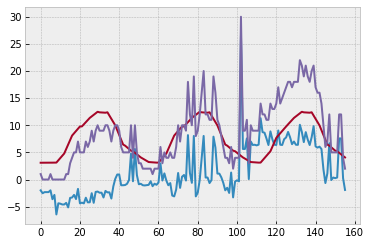

In [327]:
plt.plot(iq_resid_preds)
plt.plot(iq_monthly_preds)
plt.plot(iq_cases_pred)

4.814509737642724


Text(0,0.5,'Cases')

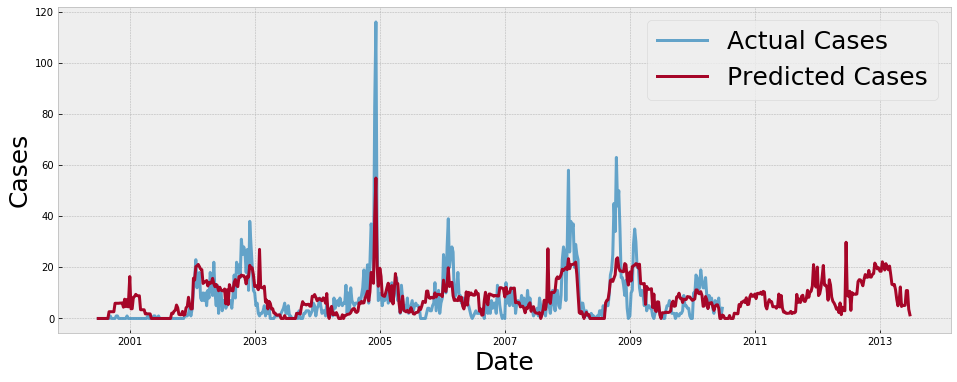

In [328]:
### make plot of best model predictions and actual cases over all time period for iq
# monthly trend
iq_month_preds = lr_iq_month.predict(pd.get_dummies(df_iq['month'], prefix='month'))
# iq_month_preds = xg_iq_month.predict(pd.get_dummies(df_iq['month'], prefix='month'))
# predicted residuals
weather1 = df_iq[['station_avg_temp_c']].rolling(window=53, min_periods=1).mean()
weather2 = df_iq[['ndvi_se']].rolling(window=53, min_periods=1).mean()
weather3 = df_iq[['reanalysis_specific_humidity_g_per_kg']].rolling(window=53, min_periods=1).mean()
# weather4 = df_iq[['reanalysis_dew_point_temp_k']].rolling(window=53, min_periods=1).mean()
weather_all = pd.concat([weather1], axis = 1)
iq_resid_predicts = lr_iq_resid.predict(weather_all)
# iq_resid_predicts = xg_iq_resid.predict(weather_all)
# monthly + residuals
pred_cases = pd.Series(iq_month_preds + iq_resid_predicts)
pred_cases = pred_cases.apply(lambda x: 0 if x < 1 else x)

plt.figure(figsize=(16, 6))
plt.plot(df_iq.index[:520], cases_iq, label = 'Actual Cases', linewidth = 3, alpha = .75)
plt.plot(df_iq.index, pred_cases, label = 'Predicted Cases', linewidth = 3)
print (mean_absolute_error(pred_cases[:520], cases_iq))

plt.legend(fontsize=25)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Cases', fontsize = 25)

In [329]:
total_preds = list(sj_cases_pred) + list(iq_cases_pred)

submission_format = pd.read_csv('./dataset/submission_format.csv')

submission_format['total_cases'] = total_preds
submission_format['total_cases'] = submission_format['total_cases'].apply(lambda x: int(x))

# Save to CSV, use current date
submission_format.to_csv('submissions/residual_prediction_weather2_RF_1_features.csv', index=False)